In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re


In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/'


Mounted at /content/drive


In [3]:
data_path = 'TM-PROJECT/Uttrakhand_recipes'
data_path


'TM-PROJECT/Uttrakhand_recipes'

In [4]:
df = pd.read_csv(root_path + "TM-PROJECT/uttarakhand_recipes.csv")

df['Ingredients'] = df['Ingredients'].str.lower()
df['Ingredients'] = df['Ingredients'].str.replace('[^a-zA-Z, ]', '', regex=True)

df.head()


,Dish_Name,Ingredients,Recipe
0,Kafuli,"spinach, fenugreek leaves, mustard oil, garlic...",Wash and finely chop spinach and fenugreek lea...
1,Bhang Ki Chutney,"hemp seeds, yoghurt, lemon juice, garlic, cumi...",Dry roast hemp seeds and grind into a fine pas...
2,Phaanu,"mixed pulses, mustard oil, cumin seeds, garlic...",Soak mixed pulses overnight and grind into a c...
3,Baadi,"urad dal flour, mustard oil, turmeric, cumin s...",Mix urad dal flour with water and spices to fo...
4,Aaloo Tamatar Ka Jhol,"potatoes, tomatoes, mustard oil, cumin seeds, ...","Heat mustard oil, add cumin seeds. Add chopped..."


In [5]:
df['Ingredient_List'] = df['Ingredients'].apply(lambda x: [i.strip() for i in x.split(',')])
df[['Dish_Name','Ingredient_List']].head()


,Dish_Name,Ingredient_List
0,Kafuli,"[spinach, fenugreek leaves, mustard oil, garli..."
1,Bhang Ki Chutney,"[hemp seeds, yoghurt, lemon juice, garlic, cum..."
2,Phaanu,"[mixed pulses, mustard oil, cumin seeds, garli..."
3,Baadi,"[urad dal flour, mustard oil, turmeric, cumin ..."
4,Aaloo Tamatar Ka Jhol,"[potatoes, tomatoes, mustard oil, cumin seeds,..."


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Ingredients'])

def recommend_similar_dishes(dish_name):
    dish_name = dish_name.lower()
    match = df[df['Dish_Name'].str.lower() == dish_name]

    if match.empty:
        print("Dish not found.")
        return

    idx = match.index[0]
    similarity = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    similar_indices = similarity.argsort()[::-1][1:6]

    print(f"\nDishes similar to {dish_name.upper()}:")
    for i in similar_indices:
        print("-", df.iloc[i]['Dish_Name'])



In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(tfidf_matrix)

df[['Dish_Name', 'Cluster']].head()


,Dish_Name,Cluster
0,Kafuli,2
1,Bhang Ki Chutney,0
2,Phaanu,0
3,Baadi,0
4,Aaloo Tamatar Ka Jhol,0


In [8]:
all_ingredients = sum(df['Ingredient_List'], [])

ingredient_counts = Counter(all_ingredients)

most_common = ingredient_counts.most_common(10)
most_common


[('mustard oil', 13),
 ('salt', 12),
 ('garlic', 11),
 ('cumin seeds', 10),
 ('turmeric', 9),
 ('jaggery', 5),
 ('green chilli', 3),
 ('rice flour', 2),
 ('yoghurt', 2),
 ('mixed pulses', 2)]

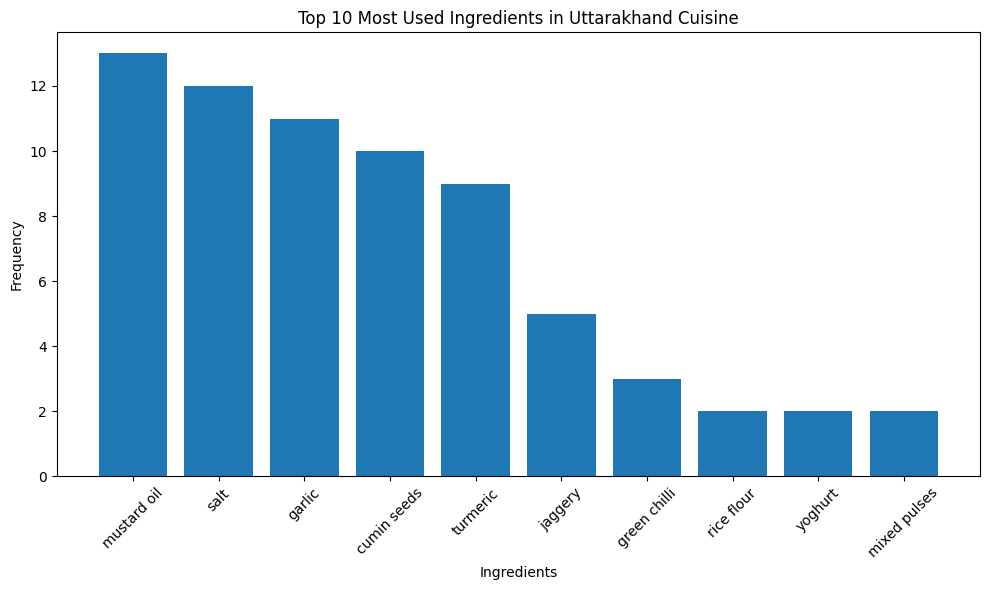

In [9]:
ingredients = [item[0] for item in most_common]
counts = [item[1] for item in most_common]

plt.figure(figsize=(10,6))
plt.bar(ingredients, counts)
plt.xticks(rotation=45)
plt.title("Top 10 Most Used Ingredients in Uttarakhand Cuisine")
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [10]:
feature_names = tfidf.get_feature_names_out()
importance = tfidf_matrix.sum(axis=0).A1

ingredient_importance = dict(zip(feature_names, importance))
sorted_importance = sorted(ingredient_importance.items(), key=lambda x: x[1], reverse=True)[:10]

sorted_importance


[('mustard', np.float64(3.107980849248153)),
 ('oil', np.float64(3.063484752875992)),
 ('seeds', np.float64(2.884383896970535)),
 ('garlic', np.float64(2.7821842039300293)),
 ('salt', np.float64(2.751749871764717)),
 ('cumin', np.float64(2.706589649772531)),
 ('turmeric', np.float64(2.5745680563582702)),
 ('flour', np.float64(1.7222746616071178)),
 ('jaggery', np.float64(1.675719343902295)),
 ('green', np.float64(1.421687337166999))]

In [11]:
def recommend_dishes(ingredient):
    ingredient = ingredient.lower()
    matching_dishes = df[df['Ingredients'].str.contains(ingredient)]

    if matching_dishes.empty:
        print("No dishes found with this ingredient.")
    else:
        print(f"Dishes containing '{ingredient}': ({len(matching_dishes)} results)\n")
        for dish in matching_dishes['Dish_Name']:
            print("-", dish)

    return matching_dishes


In [12]:
user_input = input("Enter an ingredient: ")
matched = recommend_dishes(user_input)


Enter an ingredient: yoghurt
Dishes containing 'yoghurt': (2 results)

- Bhang Ki Chutney
- Gulgula


In [13]:
def show_recipe(dish_name):
    dish = df[df['Dish_Name'].str.lower() == dish_name.lower()]

    if dish.empty:
        print("Dish not found.")
    else:
        print("\nRECIPE FOR:", dish_name.upper())
        print("-" * 50)
        print(dish['Recipe'].values[0])


In [14]:
dish_choice = input("\nEnter dish name to view recipe: ")
show_recipe(dish_choice)



Enter dish name to view recipe: Gulgula

RECIPE FOR: GULGULA
--------------------------------------------------
Mix all ingredients and deep fry small batter balls till golden.


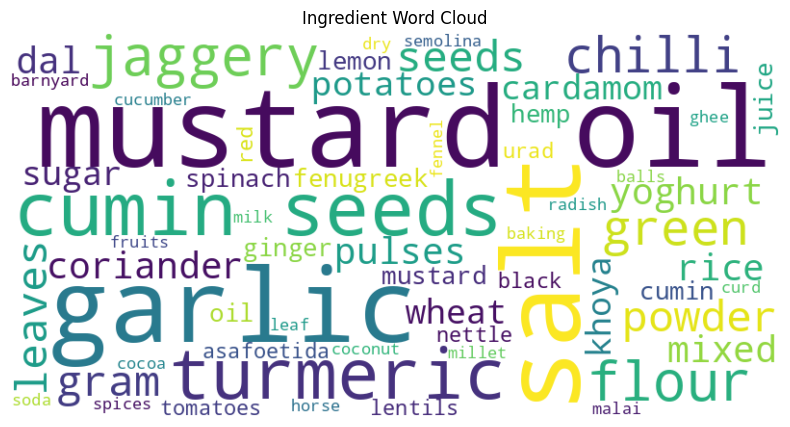

In [15]:
from wordcloud import WordCloud

text = " ".join(all_ingredients)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ingredient Word Cloud")
plt.show()
